<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/LSTM_mcfixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

With progressive growing of the sequence, the loss drops more stably. 

https://r2rt.com/non-zero-initial-states-for-recurrent-neural-networks.html

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


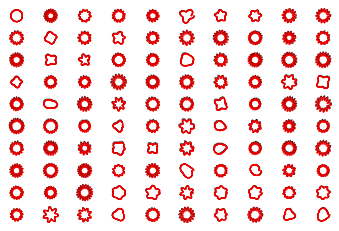

In [45]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[:,:].squeeze().cpu().numpy()
    #img = img.T
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints
            print(labels.shape,sample.shape)
            sample = torch.stack([sample for i in range(2)],dim = 0).cuda()
            labels = torch.stack([labels for i in range(2)],dim = 0).cuda()
            h0 = None
            c0 = None
            X = []
            Y = []
            for i in range(19):
              if i == 0:
                out, h0, c0,o, prevout,prevout2,prevout3 = model(sample,labels[:,i*50:50*(i+1),:2],h0,c0,prevout=None,prevout2=None,prevout3=None,ind = i)
              else:
                out, h0, c0,o, prevout,prevout2,prevout3 = model(sample,labels[:,i*50:50*(i+1),:2],h0,c0,prevout=prevout,prevout2=prevout2,prevout3=prevout3,ind = i,o = o)
                
              X.extend(out[0,:,0].tolist())
              Y.extend(out[0,:,1].tolist())

            predres = len(X)

            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            #print("type",type(X))
            ascatter = plt.scatter(X,Y,s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)
        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(X.cpu().numpy(),Y.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0]
          for el in a[1]:
            #print(c[(int)(el[1]),(int)(el[0])].item())
            #assert c[(int)(el[1]),(int)(el[0])].item() == 1
            y,x = (int)(el[1]),(int)(el[0])
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        #z = torch.zeros(numpoints,1)
        #print(z.shape)
        #points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)

DonutDataset.displayCanvas('donut.png',dataset, model = None)


In [38]:
for i in range(100):
  print(torch.sum(dataset[i][0]))

tensor(68.)
tensor(161.)
tensor(197.)
tensor(137.)
tensor(126.)
tensor(75.)
tensor(127.)
tensor(88.)
tensor(168.)
tensor(192.)
tensor(91.)
tensor(168.)
tensor(75.)
tensor(223.)
tensor(89.)
tensor(125.)
tensor(148.)
tensor(164.)
tensor(158.)
tensor(178.)
tensor(139.)
tensor(70.)
tensor(108.)
tensor(101.)
tensor(74.)
tensor(83.)
tensor(80.)
tensor(96.)
tensor(173.)
tensor(137.)
tensor(197.)
tensor(126.)
tensor(127.)
tensor(72.)
tensor(83.)
tensor(175.)
tensor(127.)
tensor(78.)
tensor(98.)
tensor(147.)
tensor(116.)
tensor(106.)
tensor(149.)
tensor(174.)
tensor(246.)
tensor(100.)
tensor(205.)
tensor(146.)
tensor(142.)
tensor(86.)
tensor(114.)
tensor(196.)
tensor(178.)
tensor(148.)
tensor(153.)
tensor(204.)
tensor(78.)
tensor(189.)
tensor(64.)
tensor(126.)
tensor(80.)
tensor(149.)
tensor(238.)
tensor(165.)
tensor(147.)
tensor(131.)
tensor(208.)
tensor(126.)
tensor(152.)
tensor(253.)
tensor(129.)
tensor(144.)
tensor(78.)
tensor(112.)
tensor(93.)
tensor(118.)
tensor(113.)
tensor(83.)
tensor(1

In [39]:

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
test_dataset = DonutDataset(length = 64)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([64, 1]) torch.Size([64, 1]) torch.Size([64, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [14]:

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
dataset = DonutDataset(length = 64*20)
loader_train = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [54]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.track = 0
        # define the properties
        self.embed_size = 2
        self.hidden_size = 256
        self.num_layers = 2
        self.seq_len = 50
        self.lm_len = 20
        self.full_len = 1000
        self.longtermMem = None
        self.longtermMemP = None
        # lstm cell
        self.lstm_cell = nn.LSTM(2+1024, self.hidden_size,self.num_layers)

        
        
        self.fc_out = nn.Sequential(
            nn.Linear(2+self.hidden_size*5+1024,10000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(10000,2),
            nn.Sigmoid()
        )
        self.hi_1 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )
        self.hi_2 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )

        self.ci_1 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )
        self.ci_2 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )

        self.alpha_1 = nn.Sequential(
            nn.Linear(self.hidden_size,self.seq_len),
            nn.Softmax()
        )

        self.embs = None #= torch.empty((self.batch_size, 1000, self.hidden_size)).cuda()
        
        
        

            
        
    def forward(self, features, captions,h0 = None, c0= None,prevout = None,prevout2 = None,prevout3 = None, ind = 0, o = None):

        assert features != None
        self.track +=1
        batch_size = features.size(0)
        

        #img_emb = torch.empty((batch_size, captions.size(1), self.hidden_size)).cuda()
        
        p0 = torch.flatten(captions[:,0,:2],start_dim=1)
        

        if o == None:
          out = p0
          #self.longtermMem = torch.zeros(batch_size,self.hidden_size,self.lm_len).cuda()
          self.embs = torch.empty((batch_size, self.seq_len, self.hidden_size)).cuda()
        else:
          out = o

        
        if h0 == None and c0 == None:
          combin_init = torch.cat([torch.flatten(features,start_dim=1),out],dim=1)
          h_0_1 = self.hi_1(combin_init)  
          h_0_2 = self.hi_2(combin_init)  
          c_0_1 = self.ci_1(combin_init)  
          c_0_2 = self.ci_2(combin_init)  
          
          h0 = torch.stack([h_0_1,h_0_2],dim = 0)
          c0 = torch.stack([c_0_1,c_0_2],dim = 0)
        
        hidden_state = h0
        cell_state = c0
        outputs = torch.empty((batch_size, captions.size(1), 2)).cuda()
        
        

        for t in range(captions.size(1)):
        
            # for the first time step the input is the feature vector
            combin_lstm = torch.cat([torch.flatten(features,start_dim=1),out],dim=1)
            output, (hidden_state, cell_state) = self.lstm_cell(combin_lstm.unsqueeze(0), (hidden_state, cell_state))

            outputs[:, t, :] = out
            self.embs[:, t, :] = output.squeeze().clone().detach()
            

            a1 = self.alpha_1(output.squeeze().clone())
            outesreada = self.embs.clone()*a1.unsqueeze(2)#clone
            outesread = torch.sum(outesreada,dim=1)
            #self.longtermMem[:,:,i] = outeswrite
            #self.longtermMem = self.longtermMem.detach()
            
            #print(torch.flatten(features,start_dim=1).shape,output.shape,out.shape)  
            if prevout==None:
              prevout = outesread.squeeze()
            if prevout2==None:
              prevout2 = outesread.squeeze()
            if prevout3==None:
              prevout3 = outesread.squeeze()
            combOut = torch.cat([torch.flatten(features,start_dim=1), output.squeeze(),out,outesread,prevout,prevout2,prevout3],dim=1)#,outesread],dim=1)
            

            out = self.fc_out(combOut)
            out = out*32.0
            # build the output tensor
            
        prevout3 = prevout2.detach()
        prevout2 = prevout.detach()
        prevout = outesread.squeeze().detach()
        #self.embs = self.embs.detach().clone()
        return outputs, hidden_state.detach(), cell_state.detach(), out.detach(),prevout,prevout2,prevout3#, captions


In [84]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class DecoderRNN(nn.Module):
    def __init__(self):
        super(DecoderRNN, self).__init__()
        self.track = 0
        # define the properties
        self.embed_size = 2
        self.hidden_size = 256
        self.num_layers = 2
        self.seq_len = 50
        self.lm_len = 20
        self.full_len = 1000
        self.longtermMem = None
        self.longtermMemP = None
        # lstm cell
        self.lstm_cell = nn.LSTM(2+1024, self.hidden_size,self.num_layers)

        
        
        self.fc_out = nn.Sequential(
            nn.Linear(2+self.hidden_size*6+1024,10000),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(10000,2),
            nn.Sigmoid()
        )
        self.hi_1 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )
        self.hi_2 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )

        self.ci_1 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )
        self.ci_2 = nn.Sequential(
            nn.Linear(2+1024,self.hidden_size),
        )

        self.alpha_1 = nn.Sequential(
            nn.Linear(self.hidden_size,self.seq_len),
            nn.Softmax()
        )

        self.alpha_long = nn.Sequential(
            nn.Linear(self.hidden_size,self.lm_len),
            nn.Softmax()
        )

        self.embs = None #= torch.empty((self.batch_size, 1000, self.hidden_size)).cuda()
        
        
        

            
        
    def forward(self, features, captions,h0 = None, c0= None,prevout = None,prevout2 = None,prevout3 = None, ind = 0, o = None):

        assert features != None
        self.track +=1
        batch_size = features.size(0)
        

        #img_emb = torch.empty((batch_size, captions.size(1), self.hidden_size)).cuda()
        
        p0 = torch.flatten(captions[:,0,:2],start_dim=1)
        

        if o == None:
          out = p0
          self.longtermMem = torch.zeros(batch_size,self.lm_len,self.hidden_size).cuda()
          self.embs = torch.empty((batch_size, self.seq_len, self.hidden_size)).cuda()
        else:
          out = o

        
        if h0 == None and c0 == None:
          combin_init = torch.cat([torch.flatten(features,start_dim=1),out],dim=1)
          h_0_1 = self.hi_1(combin_init)  
          h_0_2 = self.hi_2(combin_init)  
          c_0_1 = self.ci_1(combin_init)  
          c_0_2 = self.ci_2(combin_init)  
          
          h0 = torch.stack([h_0_1,h_0_2],dim = 0)
          c0 = torch.stack([c_0_1,c_0_2],dim = 0)
        
        hidden_state = h0
        cell_state = c0
        outputs = torch.empty((batch_size, captions.size(1), 2)).cuda()
        
        

        for t in range(captions.size(1)):
        
            # for the first time step the input is the feature vector
            combin_lstm = torch.cat([torch.flatten(features,start_dim=1),out],dim=1)
            output, (hidden_state, cell_state) = self.lstm_cell(combin_lstm.unsqueeze(0), (hidden_state, cell_state))

            outputs[:, t, :] = out
            self.embs[:, t, :] = output.squeeze().clone().detach()
            

            a1 = self.alpha_1(output.squeeze().clone())
            outesreada = self.embs.clone()*a1.unsqueeze(2)#clone
            outesread = torch.sum(outesreada,dim=1)

            self.longtermMem[:, i, :] = outesread.detach()
            
            a2 = self.alpha_long(output.squeeze().clone())
            outesreada2 = self.longtermMem.clone()*a2.unsqueeze(2)#clone
            outesread2 = torch.sum(outesreada2,dim=1)
            
            #self.longtermMem[:,:,i] = outeswrite
            #self.longtermMem = self.longtermMem.detach()
            
            #print(torch.flatten(features,start_dim=1).shape,output.shape,out.shape)  
            if prevout==None:
              prevout = outesread.squeeze()
            if prevout2==None:
              prevout2 = outesread.squeeze()
            if prevout3==None:
              prevout3 = outesread.squeeze()
            
            combOut = torch.cat([torch.flatten(features,start_dim=1), output.squeeze(),out,outesread,outesread2,prevout,prevout2,prevout3],dim=1)#,outesread],dim=1)
            

            out = self.fc_out(combOut)
            out = out*32.0
            # build the output tensor
            
        prevout3 = prevout2.detach()
        prevout2 = prevout.detach()
        prevout = outesread.squeeze().detach()
        #self.embs = self.embs.detach().clone()
        return outputs, hidden_state.detach(), cell_state.detach(), out.detach(),prevout,prevout2,prevout3#, captions


In [85]:
a = torch.ones(64,256,50)
b = torch.from_numpy(np.random.randn(50))
c = a*b
print(c[0,1,:])
print(c[1,1,:])

tensor([-0.0191, -0.4136,  0.4876, -0.6668, -0.0575, -2.0004, -2.1937, -0.3360,
        -1.5737, -0.0576,  1.8075,  0.7744, -0.8197, -0.0562, -1.5108, -1.7945,
        -0.5429, -1.3356,  1.8453, -1.3476,  0.5635, -0.8928, -2.0540, -1.7668,
         0.3509, -1.0013,  1.6801, -1.3727, -0.7524, -1.1610,  0.0104, -0.6371,
        -0.2197,  0.4031,  1.7612,  1.0371,  0.6552, -0.1756,  1.5987, -0.5784,
         0.1725, -0.3820,  0.0801,  0.2931, -0.2553, -1.2045, -2.1310, -0.4902,
         0.9377, -0.3783], dtype=torch.float64)
tensor([-0.0191, -0.4136,  0.4876, -0.6668, -0.0575, -2.0004, -2.1937, -0.3360,
        -1.5737, -0.0576,  1.8075,  0.7744, -0.8197, -0.0562, -1.5108, -1.7945,
        -0.5429, -1.3356,  1.8453, -1.3476,  0.5635, -0.8928, -2.0540, -1.7668,
         0.3509, -1.0013,  1.6801, -1.3727, -0.7524, -1.1610,  0.0104, -0.6371,
        -0.2197,  0.4031,  1.7612,  1.0371,  0.6552, -0.1756,  1.5987, -0.5784,
         0.1725, -0.3820,  0.0801,  0.2931, -0.2553, -1.2045, -2.1310, -

In [86]:
model = DecoderRNN().cuda()

In [87]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))#ideal


In [88]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


In [89]:
model = model.train()
for seql in range(3,16,4):
  #seql = 19
  for epoch in range (10):
    loss = None
    for x,y in loader_train:
      h0 = None
      c0 = None
      for i in range(seql):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        
        if i == 0:
          out, h0, c0,o, prevout,prevout2,prevout3 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,prevout=None,prevout2=None,prevout3=None,ind = i)
        else:
          out, h0, c0,o, prevout,prevout2,prevout3 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,prevout=prevout,prevout2=prevout2,prevout3=prevout3,ind = i,o = o)
        loss = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
      #print(y[:,0,:2])
      print('epoch',epoch,'seql',seql)
      print(loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 0 seql 3
tensor(10.1106, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(16.7814, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(19.8769, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(8.8711, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(4.7460, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(4.0729, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(5.2957, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(7.8169, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(7.3710, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(5.1773, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(4.1700, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(3.7516, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(3.6647, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 3
tensor(4.1799, device='cuda:0', grad_fn=<MeanB

In [90]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))#ideal



In [91]:

model = model.train()
for seql in range(15,20,4):
  #seql = 19
  for epoch in range (10):
    loss = None
    for x,y in loader_train:
      h0 = None
      c0 = None
      for i in range(seql):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        
        if i == 0:
          out, h0, c0,o, prevout,prevout2,prevout3 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,prevout=None,prevout2=None,prevout3=None,ind = i)
        else:
          out, h0, c0,o, prevout,prevout2,prevout3 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,prevout=prevout,prevout2=prevout2,prevout3=prevout3,ind = i,o = o)
        loss = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
        writer.add_scalar("Loss/train", loss, epoch)
        
        loss.backward()
        optimizer.step()
      #print(y[:,0,:2])
      print('epoch',epoch,'seql',seql)
      print(loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 0 seql 15
tensor(2.0666, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.3137, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.1897, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.1810, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(1.9958, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.1190, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.4190, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.2745, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.2254, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.0063, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.1943, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.0809, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.3080, device='cuda:0', grad_fn=<MeanBackward0>)
epoch 0 seql 15
tensor(2.3014, device='cuda:0', gra

In [ ]:
"""model = model.train()
for epoch in range (20):
  loss = None
  for x,y in loader_train:
    h0 = None
    c0 = None
    for i in range(19):
      x = x.cuda()
      y = y.cuda()
      
      optimizer.zero_grad()
      #print(x.shape,y.shape)
      if i == 0:
        out, h0, c0, o = model(x,y[:,i*50:50*(i+1),:2],h0,c0,ind = i)
      else:
        out, h0, c0, o = model(x,y[:,i*50:50*(i+1),:2],h0,c0,ind = i,o=o)
        
      loss = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
      writer.add_scalar("Loss/train", loss, epoch)

      loss.backward()
      optimizer.step()
    #print(y[:,0,:2])
    print('epoch',epoch)
    print(loss)"""

In [92]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 64
test_dataset = DonutDataset(length = 64)
loader_test = data.DataLoader(
    test_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=test_dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([64, 1]) torch.Size([64, 1]) torch.Size([64, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [93]:
model = model.eval()
for epoch in range (1):
  loss = None
  for x,y in loader_test:
    h0 = None
    c0 = None
    seql = 19
    loss = torch.zeros(seql)
    for i in range(seql):
      x = x.cuda()
      y = y.cuda()
      
      #print(x.shape,y.shape)
      if i == 0:
        out, h0, c0,o, prevout,prevout2,prevout3 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,prevout=None,prevout2=None,prevout3=None,ind = i)
      else:
        out, h0, c0,o, prevout,prevout2,prevout3 = model(x,y[:,i*50:50*(i+1),:2],h0,c0,prevout=prevout,prevout2=prevout2,prevout3=prevout3,ind = i,o = o)
        
      loss[i] = torch.mean((out-y[:,1+(50*i):1+(50*(i+1)),:2])**2)
      print(loss[i])
      writer.add_scalar("Loss/val", loss[i],i, epoch)

    #print(y[:,0,:2])
    print('epoch',epoch)
    print('test loss', torch.mean(loss))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(0.3253, grad_fn=<SelectBackward>)
tensor(0.5534, grad_fn=<SelectBackward>)
tensor(0.9148, grad_fn=<SelectBackward>)
tensor(0.9630, grad_fn=<SelectBackward>)
tensor(1.2268, grad_fn=<SelectBackward>)
tensor(1.4113, grad_fn=<SelectBackward>)
tensor(1.2109, grad_fn=<SelectBackward>)
tensor(1.2334, grad_fn=<SelectBackward>)
tensor(1.2141, grad_fn=<SelectBackward>)
tensor(1.2787, grad_fn=<SelectBackward>)
tensor(1.1841, grad_fn=<SelectBackward>)
tensor(1.1280, grad_fn=<SelectBackward>)
tensor(1.2346, grad_fn=<SelectBackward>)
tensor(1.2924, grad_fn=<SelectBackward>)
tensor(1.4146, grad_fn=<SelectBackward>)
tensor(1.4489, grad_fn=<SelectBackward>)
tensor(1.5989, grad_fn=<SelectBackward>)
tensor(1.6460, grad_fn=<SelectBackward>)
tensor(2.0180, grad_fn=<SelectBackward>)
epoch 0
test loss tensor(1.2262, grad_fn=<MeanBackward0>)


In [94]:
writer.flush()
writer.close()


**started** with .0001 then moved to .00001 learning rate (20 epochs) 
finished with .000001 lr, but didn't see much more improvement (total 60 epochs 20,20,20) extra 20 over previous comment

In [95]:
#%load_ext tensorboard

In [96]:
#!kill 3285
#%tensorboard --logdir runs

In [99]:
pred_dataset = DonutDataset(length = 100)

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


torch.Size([1000, 2]) torch.Size([32, 32])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size(

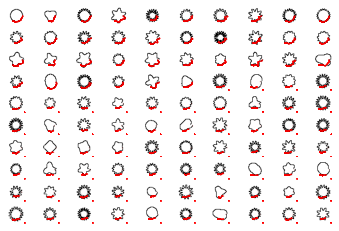

In [100]:
DonutDataset.displayCanvas('lstmpredictions.png',pred_dataset, model = model)

torch.Size([1000, 2]) torch.Size([32, 32])


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size([1000, 2]) torch.Size([32, 32])
torch.Size(

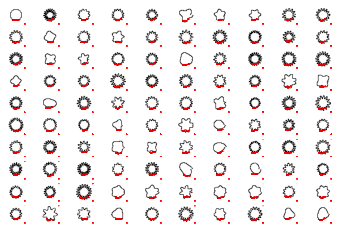

In [101]:
DonutDataset.displayCanvas('trainlstmpredictions.png',dataset, model = model)